In [191]:
from doopl.factory import *
import os
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
import sys
import matplotlib.image as mpimg
import numpy as np
from matplotlib.pyplot import figure, text
import yaml
import ast
import time
import json

In [192]:
nameFile="Created.dat"
nameFile2="ExecuteModel.mod"
nameModel="Test.mod"
modelRun="modelRun.txt"
Author="Davide Montagno Bozzone"

def find(element, matrix):
            for i in range(len(matrix)):
                for j in range(len(matrix[i])):
                    if matrix[i][j] == element:
                        return (i, j)
                    
with open("../../conf_project.yaml") as f:
    conf = yaml.load(f, Loader = yaml.FullLoader)
dpi = conf["dpi"]
node_size=conf["node_size"]

minmax= conf["minmax"]


def append_drone(n,v):
        l=[]
        for i in range(n):
            l.append(v)
        return l


Max_Capacity_BS = conf["Max_Capacity_BS"]
Workloads_rs = conf["Workloads_rs"]
check_min_drones=conf["find_min_drones"]

In [193]:
print("Starting")
n_drones=14
for Workloads_r in Workloads_rs:
    
    """for i in range(100):
        Workloads_r.append(Workloads_r[-1])"""
    Length_VNF_r = [len(x)-1 for x in Workloads_r]
    Workloads_r = [[x for x in element] for element in Workloads_r]
    stop=True
    index=0
    sol=[]
    InstPowerVolo = []

    Capacity_CPU_d = []
    Capacity_Radio_d = []

    Cost_Radio_d = []
    Cost_CPU_d = []

    Cost_CPU_d_idle = []
    Cost_Radio_d_idle = []



    BJ = []
    CA = []
    CB = []

    last_cycle=True
    Drones =  { }  
    Reqs = {}
    length_max=0
    n=n_drones
    start = time.time()

    while stop==True:
        
        sol=[]
        InstPowerVolo = []

        Capacity_CPU_d = []
        Capacity_Radio_d = []

        Cost_Radio_d = []
        Cost_CPU_d = []

        Cost_CPU_d_idle = []
        Cost_Radio_d_idle = []

        BJ = []
        CA = []
        CB = []


        Drones =  { }  
        Reqs = {}
        print("Tried with "+str(n)+" drones")
        InstPowerVolo=[]
        InstPowerVolo = append_drone(n,conf["InstPowerVolo"][0])
        Capacity_CPU_d=[]
        Capacity_CPU_d = append_drone(n,conf["Capacity_CPU_d"][0])
        Capacity_Radio_d=[]
        Capacity_Radio_d = append_drone(n,conf["Capacity_Radio_d"][0])
        Cost_Radio_d=[]
        Cost_Radio_d = append_drone(n,conf["Cost_Radio_d"][0])
        Cost_CPU_d=[]
        Cost_CPU_d = append_drone(n,conf["Cost_CPU_d"][0])
        Cost_CPU_d_idle=[]
        Cost_CPU_d_idle = append_drone(n,conf["Cost_CPU_d_idle"][0])
        Cost_Radio_d_idle=[]
        Cost_Radio_d_idle = append_drone(n,conf["Cost_Radio_d_idle"][0])
        Drones =  { x for x in range(len(Capacity_CPU_d))}  
        Reqs = {x for x in range(len(Workloads_r))}
        length_max=max(Length_VNF_r)

        BJ=[]
        BJ = append_drone(n,conf["BJ"][0])
        CA=[]
        CA = append_drone(n,conf["CA"][0])
        CB=[]
        CB = append_drone(n,conf["CB"][0])

        

        ## CREATE DATA FILE

        #THIS CODE IS USED SINCE CPLEX DOESN'T ALLOW SOME KIND OF INITIALIZATION

        if os.path.exists("./"+nameFile2):
            print("Removed "+nameFile2)
            os.remove("./"+nameFile2)
        
        file1 = open('./'+nameModel, 'r')
        Lines = file1.readlines()
        count = 0
        change=True
        # Strips the newline character
        with open("./"+nameFile2, "w+") as model:
            model.write("/*********************************************\n"+
        "* OPL 12.10.0.0 Data\n"+
        "* Author: "+Author+"\n"+
        "* Creation Date: "+str( datetime.now())+"\n"+
        "*********************************************/\n")
            for line in Lines:
                count += 1
                if("maximize" in line.strip() or "minimize" in line.strip()):
                    model.write(minmax+"\n")
                else:
                    if("Workloads_r" in line.strip() and change):
                        line_new = line.strip()
                        split = line_new.split(".")
                    
                        out = split[0]+".."+str(length_max)+"] = ...;\n"
                        model.write(out)
                    
                        change=False
                    else:
                        model.write(line+"\n")


        if os.path.exists("./"+nameFile):
            print("Removed "+nameFile)
            os.remove("./"+nameFile)

        if os.path.exists("./"+"Created.dat"):
            print("Removed "+"Created.dat")
            os.remove("./"+"Created.dat")
        with open("Created.dat","w+") as f:
            f.write("/*********************************************\n"+
        "* OPL 12.10.0.0 Data\n"+
        "* Author: "+Author+"\n"+
        "* Creation Date: "+str( datetime.now())+"\n"+
        "*********************************************/\n")
            f.write("Drones = "+str(Drones)+";\n")
            f.write("Reqs = "+str(Reqs)+";\n")
        
            
            f.write("BJ = "+str(BJ)+";\n")
            f.write("Capacity_CPU_d = "+str(Capacity_CPU_d)+";\n")
            f.write("Capacity_Radio_d = "+str(Capacity_Radio_d)+";\n")
            f.write("Cost_CPU_d = "+str(Cost_CPU_d)+";\n")
            f.write("Cost_Radio_d = "+str(Cost_Radio_d)+";\n")

            f.write("Max_Capacity_BS = "+str(Max_Capacity_BS)+";\n")
            f.write("Workloads_r = "+str(Workloads_r)+";\n")
            f.write("Length_VNF_r = "+str(Length_VNF_r)+";\n")
            f.write("length_max = "+str(length_max)+";\n")
            f.write("InstPowerVolo = "+str(InstPowerVolo)+";\n")
            f.write("Cost_CPU_d_idle = "+str(Cost_CPU_d_idle)+";\n")
            f.write("Cost_Radio_d_idle = "+str(Cost_Radio_d_idle)+";\n")
            f.write("CA = "+str(CA)+";\n")
            f.write("CB = "+str(CB)+";\n")

        # Create an OPL model from a .mod file
        with create_opl_model(model="ExecuteModel.mod",data="Created.dat") as opl:
            # Generate the problem and solve it.
            status = opl.run()
        
        """ 
        Parsing file
        """
        if os.path.exists("./"+"Created.dat"):
            print("Removed "+"Created.dat")
            os.remove("./"+"Created.dat")
        count = 0
        check=True
        decision = ""
        if os.path.exists("./text.txt"):
            print("Removed text")
            os.remove("./text.txt")
        if os.path.exists("./text2.txt"):
            print("Removed tex2t")
            os.remove("./text2.txt")
        with open ("text.txt","w+") as f2:
            with open("modelRun.txt", "r") as f:
                        lines = f.readlines()
                        final_s = ""
                        check=False
                        print(len(lines))
                        for line in lines:
                            
                            if("Decision =" in line):
                                
                                res=line.split("Decision = ")[1].replace(" ",",").strip().replace(";","")+","
                               
                                final_s+=res
                                check=True
                               
                            if("Decision =" not in line and check):
                                
                                
                                res=line.strip().replace(" ",",").replace(";","")
                                
                                if("]" in res):
                                    
                                    res=res.replace("\n","")+","
                                   
                                    final_s+=(res)
                              
                                else:
                                    res=res+","
                                   
                                    final_s+=(res)
                                 
                            
                            
                        print("CIAOOOOOOOOO")
                        final_s=final_s.replace(",]","]").replace(",,","")
                        f2.write(final_s)   
                        f2.close()
                        """print("CIAOOOOOOOOO")
                        print(final_s)      
                        """
                        f.close()
                        if os.path.exists("./"+modelRun):
                            print("Removed "+modelRun)
                            os.remove("./"+modelRun)
                        
                        try:
                            with open('text.txt',"r") as f:
                                lst = json.load(f)
                                with open('text2.txt',"w") as f2:
                                    f2.write(str(lst))
                            print("solution computing")
                            sol = lst
                            n=n-1
                            print("Solution is computed..............................")
                            os.remove("./text.txt")
                            os.remove("./text2.txt")
                            stop=False
                        except:
                            print("Problem not solvable..")
                            stop=False

Starting
Tried with 14 drones
Removed ExecuteModel.mod
Removed Created.dat
5226
CIAOOOOOOOOO
Removed modelRun.txt
solution computing
Solution is computed..............................


In [194]:

"""
Check consistency path
"""
"""date = str(datetime.now())
folder="./plots/Reqs/"+(date.split(".")[0]).replace(" ","_").replace(":","-")+"_len"+str(len(Workloads_r))
os.mkdir(folder) """ 
paths=[]
cons=False
sol
for r in range(len(sol)):
    sol_r = sol[r][:len(Workloads_rs[0][r])]
    path_r = []
    print("VNF applied for req",r+1,":",(len(sol_r)-1))
    for level in sol_r:
        path_r.append(find(1,level))
    #DEBUG
    for i in range(len(path_r)-1):
        if(path_r[i][1] != path_r[i+1][0]):
            print("Path consistency problem")
            cons=True
        else:
            pass
    paths.append(path_r)

paths_now = [[paths[z]] for z in range(len(paths))]
real_path = [[paths_now[j][0][i] for i in range(len(paths_now[j][0]))] for j in range(len(paths_now))]
if(cons):
    print("The final path not satisfies the flow constraints.")
    exit()
else:
    """"
    Extracting instantaneour power
    """   
    instPower_d = [0 for x in Drones]
    instPower_r = [[] for x in range(len(Drones))]
    percentage_active_CPU_r = [[] for x in range(len(Drones))]
    percentage_active_Radio_r = [[] for x in range(len(Drones))]

    for element in range(len(instPower_r)):
        for workload in Workloads_r:
            instPower_r[element].append([])
            percentage_active_CPU_r[element].append([])
            percentage_active_Radio_r[element].append([])
    
    added = [0 for x in Drones]
    for r in range(len(Workloads_r)):
            if(paths[r][0][0]!=len(Drones)):
                total=0
                tmp = 0
                
                drone = paths[r][0][0]
                if(added[drone]==0):
                    instPower_d[drone]+=InstPowerVolo[drone]
                    added[drone]=1
                
                # x_<i,0><i,1>^r
                if(paths[r][0][0] == paths[r][0][1]):

                    tmp = (Workloads_r[r][0] / Capacity_CPU_d[paths[r][0][0]]) * Cost_CPU_d[paths[r][0][0]]\
                    +(Workloads_r[r][0] / Capacity_Radio_d[paths[r][0][0]]) * Cost_Radio_d[paths[r][0][0]]  

                    total+=tmp

                    
                    instPower_r[paths[r][0][0]][r].append(tmp)

                    tmp = (Workloads_r[r][0] / Capacity_CPU_d[paths[r][0][0]]) 
                    percentage_active_CPU_r[paths[r][0][0]][r].append(tmp)
                    percentage_active_Radio_r[paths[r][0][0]][r].append((Workloads_r[r][0] / Capacity_Radio_d[paths[r][0][0]]))
                
                else:
                    total+=2*(Workloads_r[r][0] / Capacity_Radio_d[paths[r][0][0]]) * Cost_Radio_d[paths[r][0][0]]
                    tmp = 2*(Workloads_r[r][0] / Capacity_Radio_d[paths[r][0][0]]) * Cost_Radio_d[paths[r][0][0]]
                    instPower_r[paths[r][0][0]][r].append(tmp)
                    tmp = 2*(Workloads_r[r][0] / Capacity_Radio_d[paths[r][0][0]]) 
                
                    percentage_active_Radio_r[paths[r][0][0]][r].append(tmp)
                    percentage_active_CPU_r[paths[r][0][0]][r].append(0)
                
                for i in range(len(   paths[r][1:(len(paths[r]))] )):
                    idx=i+1
                    
                    element = paths[r][idx]
                    if(element[0]!=len(Drones)):
                        
                        if(element[0] == element[1]):
                            total+=(Workloads_r[r][idx-1] / Capacity_CPU_d[element[0]]) * Cost_CPU_d[element[0]]
                            tmp=(Workloads_r[r][idx-1] / Capacity_CPU_d[element[0]]) * Cost_CPU_d[element[0]]
                            instPower_r[element[0]][r].append(tmp)
                            tmp = (Workloads_r[r][idx] / Capacity_CPU_d[element[0]])
                            percentage_active_CPU_r[paths[r][0][0]][r].append(tmp)
                            percentage_active_Radio_r[paths[r][0][0]][r].append(0)
                    
                        else:
                            total+=(Workloads_r[r][idx] / Capacity_Radio_d[element[0]]) * Cost_Radio_d[element[0]] 
                            tmp = (Workloads_r[r][idx] / Capacity_Radio_d[element[0]]) * Cost_Radio_d[element[0]] 
                            instPower_r[element[0]][r].append(tmp)
                            tmp = (Workloads_r[r][idx] / Capacity_Radio_d[element[0]])
                            percentage_active_Radio_r[paths[r][0][0]][r].append(tmp)
                            percentage_active_CPU_r[paths[r][0][0]][r].append(0)
                    
                
                instPower_d[drone]+=total

VNF applied for req 1 : 1
VNF applied for req 2 : 1
VNF applied for req 3 : 1
VNF applied for req 4 : 1
VNF applied for req 5 : 1
VNF applied for req 6 : 1
VNF applied for req 7 : 1
VNF applied for req 8 : 1
VNF applied for req 9 : 1
VNF applied for req 10 : 1
VNF applied for req 11 : 1
VNF applied for req 12 : 1
VNF applied for req 13 : 1
VNF applied for req 14 : 1
VNF applied for req 15 : 1
VNF applied for req 16 : 1
VNF applied for req 17 : 1
VNF applied for req 18 : 1
VNF applied for req 19 : 1
VNF applied for req 20 : 1
VNF applied for req 21 : 1
VNF applied for req 22 : 1
VNF applied for req 23 : 1
VNF applied for req 24 : 1
VNF applied for req 25 : 1
VNF applied for req 26 : 1
VNF applied for req 27 : 1
VNF applied for req 28 : 1
VNF applied for req 29 : 1
VNF applied for req 30 : 1
VNF applied for req 31 : 1
VNF applied for req 32 : 1
VNF applied for req 33 : 1
VNF applied for req 34 : 1
VNF applied for req 35 : 1
VNF applied for req 36 : 1
VNF applied for req 37 : 1
VNF applie

In [195]:
""" 
PLOTS ASSIGNED VNF STARTING FROM CPLEX SOLUTION
"""
for root, dirs, files in os.walk('./plots/processing/'):
        for f in files:
            os.unlink(os.path.join(root, f))


import numpy as np
from matplotlib.pyplot import figure
import json

print(real_path)
print("-----------------------------------------------------")

G = nx.MultiDiGraph()
"""G.add_node("Map", image="./img/map.png", level=1)
G.add_node("BS", image="./img/antenna.png", level=3)"""
edge_labels = []
tot=0
tot_processed=0
total =[]
for r in range(len(real_path)):
    real_path[r]=real_path[r][:-1]
    actual_drone=real_path[r][0][0]
    vnf_processed=[x[1] for x in real_path[r]]
    vnf_processed=next((i for i in range(len(vnf_processed)) if vnf_processed[i] !=actual_drone), None)
    reacheable_BS=next((i for i in range(len(Workloads_r)) if Workloads_r[r][i] < Max_Capacity_BS), None)
    #plt.title("Req "+str(r+1)+"\nAssigned "+str(vnf_processed if vnf_processed!=None else 1)+" VNF to Drone "+str(actual_drone)+"\n"+\
                #("BS reacheable at "+str(reacheable_BS+1)+"° VNF" if reacheable_BS!=None else "Cannot assign VNFs to BS due to its capacity flow constraint"))
    
    
    if(actual_drone!=len(Drones)):
        UAV_name_r = "UAV_"+str(actual_drone)+"_"+str(r)
        #G.add_node(UAV_name_r, image="./img/drone.png", level=2)
        
    
    
        if(vnf_processed==None):
            print("Request completely assigned to drone",actual_drone, Length_VNF_r[r], Workloads_r[r])
            
            tot_processed+=Length_VNF_r[r]-Length_VNF_r[r]
            tot+=sum(Workloads_r[r][Length_VNF_r[r]:-1])
            total.append((actual_drone,sum(Workloads_r[r][:-1]),(Length_VNF_r[r],Length_VNF_r[r]),0))
        else:
            print("VNF assigned to drone",actual_drone ,":",vnf_processed,Workloads_r[r])
            
            if(vnf_processed==Length_VNF_r[r]):
                total.append((actual_drone,sum(Workloads_r[r][:vnf_processed]),(vnf_processed,Length_VNF_r[r]), Workloads_r[r][-1]))
            else:
                total.append((actual_drone,sum(Workloads_r[r][:vnf_processed]),(vnf_processed,Length_VNF_r[r]),sum(Workloads_r[r][:-1]) - sum(Workloads_r[r][:vnf_processed]) ))
    else:
            tot+=sum(Workloads_r[r][:-1])
            tot_processed+=Length_VNF_r[r]
            print("VNF assigned to BS directly from the crowd: ",Length_VNF_r[r],Workloads_r[r])
            total.append((-1,sum(Workloads_r[r][:-1]),(Length_VNF_r[r],Length_VNF_r[r]),0))

[[(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(14, 14), (14, 14)], [(0, 0), (0, 0), (0, 14)], [(14, 14), (14, 14), (14, 14)], [(14, 14), (14, 14), (14, 14)], [(3, 3), (3, 3), (3, 14)], [

In [196]:
from itertools import groupby
from operator import itemgetter
print(total)


dictwork = {
}
for element in total:
    if element[0] not in dictwork:
        dictwork[element[0]]=element[1]
    else:
        dictwork[element[0]]+=element[1]



dictremaining = {
}
tot_to_add = 0
for element in total:
    if element[0] not in dictremaining:
        dictremaining[element[0]]=element[3]
    else:
        dictremaining[element[0]]+=element[3]
    tot_to_add += element[3]


processed_vnf = {
}
total_seen_vnf = {
}
tot_to_add2 = 0
tot_proc=0
for element in total:
    if element[0] not in total_seen_vnf:
        tot_proc=element[2][0]
        processed_vnf[element[0]]=element[2][0]
        total_seen_vnf[element[0]]=element[2][1]
    else:
        tot_proc+=element[2][0]
        processed_vnf[element[0]]+=element[2][0]
        total_seen_vnf[element[0]]+=element[2][1]
    tot_to_add2 += element[2][1] - element[2][0]




# LATEX PART
print('\\begin{table}[h]\n\t\\centering\n\t\\begin{tabular}{|c|c|c|c|c|c|c|c|c|}\n\t\\hline')
print("\t\t\\tiny{$BJ_i-CA_i-CB_i$} & $CC_i$ & $CR_i$ & $P_i^R$  & $LG(i)$  & $dg_i^{proc-active}$ & $dg_i^{radio-active}$ & \\tiny{VNF Processed} & Tot $\\frac{Gb}{s}$ &\n\t\\hline")
i=0
BJ_i = [(BJ[d]-CA[d]-CB[d],d) for d in Drones]
P_i_f = [(instPower_d[d],d) for d in Drones]
througput_drones=0
used=0
for d in sorted(sorted(P_i_f)):
        d=d[1]
        if(instPower_d[d]!=0):
                used=used+1
                #print(d,dictwork[d],dictremaining[d],(processed_vnf[d],total_seen_vnf[d]))
                before=instPower_d[d]
                cpu_active = np.sum([np.sum(x) for x in percentage_active_CPU_r[d]])
                radio_active = np.sum([np.sum(x) for x in percentage_active_Radio_r[d]])
                cpu_idle = (1-cpu_active)
                radio_idle = (1-radio_active)
                instPower_d[d] = (instPower_d[d] + Cost_CPU_d_idle[d] * cpu_idle + Cost_Radio_d_idle[d] * radio_idle )
                int_tot=instPower_d[d]
                througput_drones+=dictwork[d]
                print("\t\\bf "+str(BJ[d]-CA[d]-CB[d])+" & "+str(Capacity_CPU_d[d])+" & "+str((Capacity_Radio_d[d]))+" & "+str(int_tot)[:5]+" & "+str(((BJ[d]-CA[d]-CB[d]) / int_tot))[:5]+
                    "  & "+str(cpu_active)[:5]+" & "+str(radio_active)[:5]+" & "+str(processed_vnf[d])+" & "+str(dictwork[d])+" &\n\t\\hline")
                i=i+1
                
print("\\end{tabular}\n\
    \\caption{Drones information after assigned set of request R}\n\
    \\label{tab:ex2.1}\n\
\\end{table}")      

print('\\begin{table}[h]\n\t\\centering\n\t\\begin{tabular}{|c|c|c|c|c|c|c|}\n\t\\hline')
print("\t\\bf $C_{max}^{BS}$ & \\bf C2B  $\\frac{Gb}{s}$ & \\bf Total VNF C2B & \\bf D2B $\\frac{Gb}{s}$ & \\bf Total VNF D2B & \\bf Total $\\frac{Gb}{s}$ & \\bf Total VNF &\n\t\\hline")
print("\t"+str(Max_Capacity_BS)+" & "+str(dictwork[-1])[:5]+" & "+str(processed_vnf[-1])+" & "+str(tot_to_add)+" & "+str(tot_to_add2)+" & "+str(dictwork[-1]+tot_to_add)[:5]+" & "+str(processed_vnf[-1]+tot_to_add2)+" &")
                
print("\t\\hline\n\
    \\end{tabular}\n\
    \\caption{Base Station information}\n\
    \\label{tab:ex2.2}\n\
\\end{table}")  

print(-1,dictwork[-1],0,(processed_vnf[-1],total_seen_vnf[-1]), "------>",dictwork[-1]+tot_to_add,total_seen_vnf[-1]+tot_to_add2)
print("-------------------------------------------------")
print("Metrics evaluation")
total_processed_traffic=dictwork[-1]+tot_to_add+througput_drones
print("Throughput", str(total_processed_traffic))
enhanc = (total_processed_traffic-Max_Capacity_BS) / Max_Capacity_BS
if(enhanc <= 0):
    print("Enhancement in performance due to the addition of drones is:", str(0))
else:
    print("Enhancement in performance due to the addition of drones is:", str(enhanc))
print("Tried drones used: ",used)

tmp=processed_vnf.pop(-1)
print("Processed VNF vs Total VNF ratio: ",(tmp+tot_to_add2+sum(list(processed_vnf.values())))/sum([x for x in Length_VNF_r]))
processed_vnf[-1] = tmp
print("---------------------------------------------------------")

[(-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1, 1), 0), (-1, 470.5882352941176, (1,

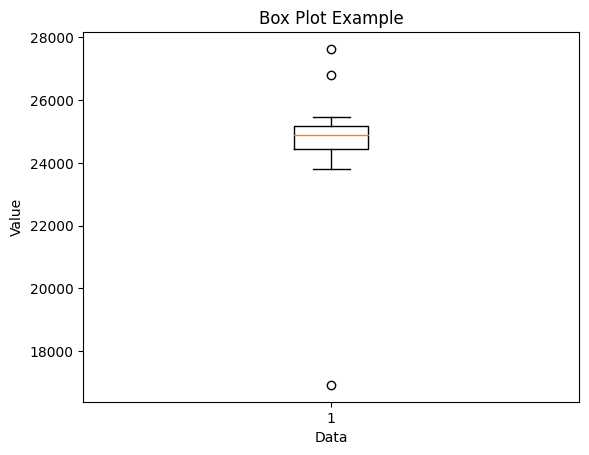

In [197]:
from matplotlib.pyplot import figure
l_d=[]
list_files = os.listdir("../raw_data/")
for file in list_files:
    tmp=[]
    with open("../raw_data/"+file) as f:
        print(file)
        lines = f.readlines()
        for line in lines:
            line=line.replace("\n","")
            if("\\end" in line):
                break
            if("\\bf" in line):
                try:
                    res=float(line.split("&")[4])
                    tmp.append(res)
                except:
                    print(line)
    l_d.append(tmp)
print([len(l_d[i]) for i in range(len(l_d))])
for i in range(len(l_d)):
    print("Group "+str(i)+"="+str(l_d[i]))
            
            
import matplotlib.pyplot as plt

# Sample data

# Create a figure and axis object
fig, ax = plt.subplots()

# Create a box plot
ax.boxplot(l_d)

# Add labels and title
ax.set_xlabel('Data')
ax.set_ylabel('Value')
ax.set_title('Box Plot Example')

# Display the plot
plt.show()

            
if(minmax=="minimize"):
        #plt.savefig(folder+"/max_R_info.jpg", bbox_inches='tight', dpi=dpi)
        print("")
else:
    #plt.savefig(folder+"/min_R_info.jpg", bbox_inches='tight', dpi=dpi)
    print("")